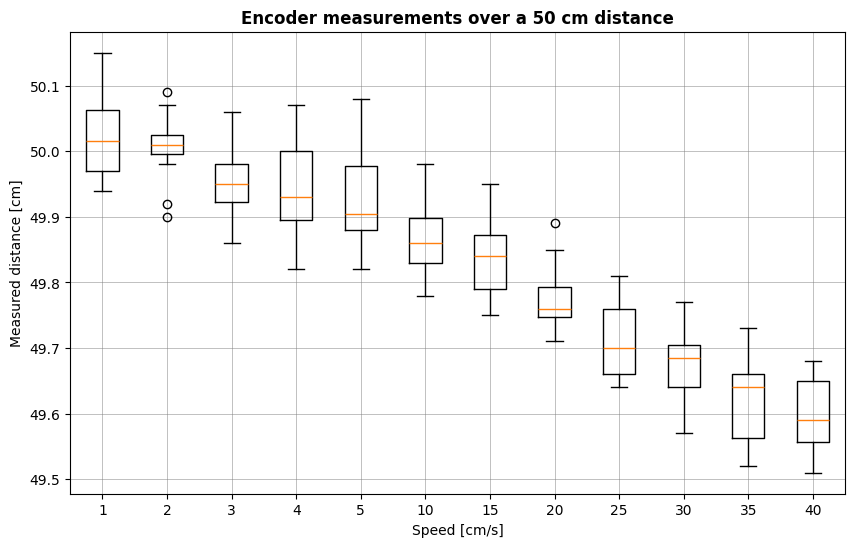

In [20]:
import os
import re
import pandas as pd

import matplotlib.pyplot as plt

# Find all relevant CSV files
files = [f for f in os.listdir('.') if re.match(r'exp\d+_(backward|forward)\.csv', f)]

# Dictionary to hold measurements per experiment
exp_data = {}

for file in files:
    match = re.match(r'exp(\d+)_(backward|forward)\.csv', file)
    if match:
        exp_id = int(match.group(1))
        df = pd.read_csv(file)
        # Take absolute values of esp32_enc_sing
        values = df['esp32_enc_sing'].abs()
        if exp_id in exp_data:
            exp_data[exp_id].extend(values)
        else:
            exp_data[exp_id] = list(values)

experiment_speeds = {
    '1': '1',
    '2': '2',
    '3': '3',
    '4': '4',
    '5': '5',
    '6': '10',
    '7': '15',
    '8': '20',
    '9': '25',
    '10': '30',
    '11': '35',
    '12': '40'
}

# Sort experiments by ID
sorted_exp_ids = sorted(exp_data.keys())
data_for_plot = [exp_data[exp_id] for exp_id in sorted_exp_ids]

# Plot boxplot
plt.figure(figsize=(10, 6))
# Add gray horizontal grid lines for easier reading
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.7, alpha=0.5)
plt.grid(axis='x', color='gray', linestyle='-', linewidth=0.7, alpha=0.5)

plt.boxplot(
    data_for_plot,
    tick_labels=[experiment_speeds[str(exp_id)] for exp_id in sorted_exp_ids],
)
plt.xlabel('Speed [cm/s]')
plt.ylabel('Measured distance [cm]')
plt.title('Encoder measurements over a 50 cm distance', fontweight='semibold')
plt.show()

Successfully loaded 'OpenSans-Regular.ttf' as family 'Open Sans'
Successfully loaded 'Montserrat-Bold.ttf' as family 'Montserrat'
Processing 24 files...
Visualization saved to error_analysis.png


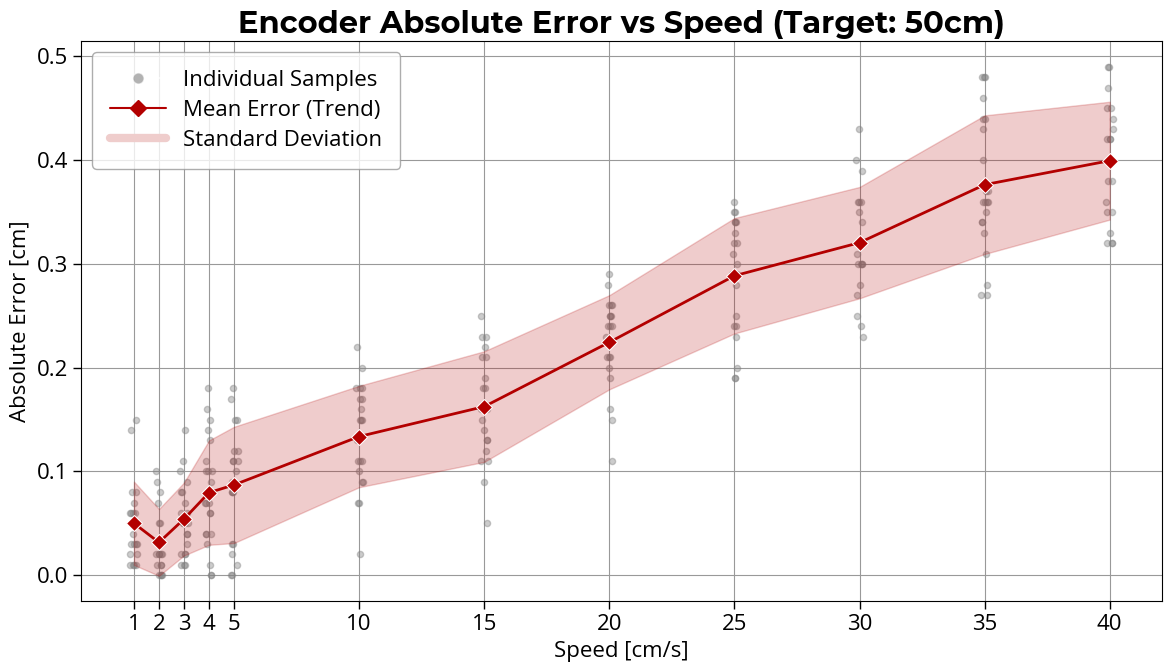

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import os
import numpy as np  # Added for numerical operations
import matplotlib.font_manager as fm
import urllib.request

# --- CONFIGURATION: LOCAL FONTS ---
# specific paths provided by user (corrected .ttt to .ttf)
LOCAL_FONT_PATHS = [
    "/Users/danilopimentel/Downloads/Montserrat,Open_Sans/Open_Sans/static/OpenSans-Regular.ttf",
    "/Users/danilopimentel/Downloads/Montserrat,Open_Sans/Montserrat/static/Montserrat-Bold.ttf"
]

def setup_local_fonts():
    """
    Loads fonts from specific local paths provided by the user.
    Returns a dictionary mapping the filename to the internal Matplotlib family name.
    """
    loaded_families = {}

    for font_path in LOCAL_FONT_PATHS:
        # Check if file exists
        if not os.path.exists(font_path):
            print(f"WARNING: Font file not found at: {font_path}")
            continue
        
        try:
            # Register the font
            fm.fontManager.addfont(font_path)
            
            # Get the exact family name Matplotlib assigns to this file
            prop = fm.FontProperties(fname=font_path)
            family_name = prop.get_name()
            
            # Key is the filename (e.g., 'OpenSans-Regular.ttf'), Value is family name
            filename = os.path.basename(font_path)
            loaded_families[filename] = family_name
            print(f"Successfully loaded '{filename}' as family '{family_name}'")
            
        except Exception as e:
            print(f"Error loading font {font_path}: {e}")
            
    return loaded_families


def analyze_experiments():
    setup_local_fonts()

    # Configuration
    FILE_PATTERN = "exp*_*.csv"  # Matches exp{id}_{speed}_{direction}.csv
    TARGET_DISTANCE = 50.0      # The ground truth for all experiments
    MEASURE_COL = 'esp32_enc_sing'
    
    # 1. Gather Data
    all_data_frames = []
    files = glob.glob(FILE_PATTERN)
    
    if not files:
        print("No files found matching the pattern. Please ensure the script is in the correct folder.")
        return

    print(f"Processing {len(files)} files...")

    for filename in files:
        # Regex to extract speed from "exp{id}_{speed}_{direction}.csv"
        match = re.search(r"exp\d+_([0-9\.]+)_", filename)
        
        if match:
            try:
                current_speed = float(match.group(1))
                
                # Load the CSV
                df = pd.read_csv(filename)
                
                # Validation: Ensure column exists
                if MEASURE_COL not in df.columns:
                    print(f"Warning: Column '{MEASURE_COL}' not found in {filename}")
                    continue
                
                # 2. Calculate Error for EVERY row
                df['absolute_measure'] = df[MEASURE_COL].abs()
                df['error_cm'] = (df['absolute_measure'] - TARGET_DISTANCE).abs()
                df['speed'] = current_speed
                
                clean_df = df[['speed', 'error_cm']].copy()
                all_data_frames.append(clean_df)
                
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    # 3. Combine Data
    if not all_data_frames:
        print("No valid data extracted.")
        return

    full_dataset = pd.concat(all_data_frames, ignore_index=True)
    
    # Sort by speed
    full_dataset.sort_values(by='speed', inplace=True)

    # 4. Generate Visualization
    plt.figure(figsize=(12, 7))
    # sns.set_style("whitegrid")
    sns.set_style("whitegrid", {'grid.color': '#999999', 'grid.linestyle': '-'})
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['right'].set_color('black')
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    # Ensure ticks are visible and styled
    plt.tick_params(axis='x', which='both', direction='out', length=6, color='black', width=1)
    plt.tick_params(axis='y', which='both', direction='out', length=6, color='black', width=1)
    plt.gca().tick_params(bottom=True, left=True, top=False, right=False)
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Open Sans'],
        'font.size': 16,
        'font.weight': '200'
    })
    plt.title('Encoder Absolute Error vs Speed (Target: 50cm)', fontsize=22, pad=20, fontname='Montserrat')

    # Dynamic Jitter Calculation:
    # We want points to spread out slightly so they don't overlap, 
    # but the spread must be small enough not to touch the next speed value.
    unique_speeds = np.sort(full_dataset['speed'].unique())
    if len(unique_speeds) > 1:
        # Find the smallest gap between speeds and take 15% of it
        min_gap = np.min(np.diff(unique_speeds))
        jitter_val = min_gap * 0.15
    else:
        jitter_val = 0.1

    # A. Individual Points (Scatter)
    # We use regplot with fit_reg=False because it handles "x_jitter" on numeric axes perfectly.
    sns.regplot(
        data=full_dataset,
        x='speed',
        y='error_cm',
        fit_reg=False,       # Disable the regression line, we just want the points
        x_jitter=jitter_val, # Jitter to see density
        color='gray',
        scatter_kws={'alpha': 0.4, 's': 20},
        label='Individual Measure'
    )

    # B. Trend Line (Mean + Confidence Interval)
    # lineplot automatically treats 'Speed' as a continuous number, fixing the axis spacing.
    sns.lineplot(
        data=full_dataset,
        x='speed',
        y='error_cm',
        estimator='mean',
        errorbar='sd',       # Standard Deviation (shaded area)
        color='#b30000',
        marker='D',          # Diamond marker for the mean points
        markersize=8,
        label='Mean Error',
        linewidth=2
    )

    # Formatting
    plt.title('Encoder Absolute Error vs Speed (Target: 50cm)', fontsize=22)
    plt.ylabel('Absolute Error [cm]', fontsize=16)
    plt.xlabel('Speed [cm/s]', fontsize=16)
    
    # Force all x-axis labels to show
    plt.xticks(unique_speeds)
    
    # Custom Legend Handling
    # Re-creating the legend to ensure it looks clean
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='Individual Samples', markersize=8, alpha=0.6),
        Line2D([0], [0], color='#b30000', marker='D', label='Mean Error (Trend)', markersize=8),
        Line2D([0], [0], color='#EFCDCC', lw=6, label='Standard Deviation')
    ]
    leg = plt.legend(
        handles=legend_elements,
        loc='upper left',
        frameon=True,
        borderpad=.8,      # inside border padding
        labelspacing=.4,   # vertical space between labels
        handlelength=2.5,
        handletextpad=0.8,
        borderaxespad=.5   # padding between axes and legend
    )
    leg.get_frame().set_edgecolor('#999999')
    leg.get_frame().set_linewidth(1.0)


    # Save and Show
    plt.tight_layout()
    output_filename = 'error_analysis.png'
    plt.savefig(output_filename, dpi=300)
    output_pdf = 'error_analysis.pdf'
    plt.savefig(output_pdf, format='pdf')
    plt.savefig(output_filename, dpi=300)
    print(f"Visualization saved to {output_filename}")
    plt.show()

if __name__ == "__main__":
    analyze_experiments()